In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
def prepare_df():
    df = pd.read_excel('./Datasets/tobacco_data_v2.xlsx')
    df.columns = df.iloc[0]
    df = df[1:]
    
    # Map age group to integer
    avg_age_mapping = {
        '0-14': 7,
        '15-24': 20,
        '25-44': 33,
        '45-64': 55,
        '65+': 75
    }
    
    # Map gender to integer
    gender_mapping = {
        'Male': 0,
        'Female': 1
    }

    # Map ethnicity to integer
    ethnicity_mapping = {
        'Māori': 0,
        'non-Māori': 1
    }
    
    # Apply the mapping to the 'Age_Group' column
    df['average_age'] = df['age'].map(avg_age_mapping)
    df['gender_idx'] = df['gender'].map(gender_mapping)
    df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)
    
    # Impute missing values in 'average_age' with the mean
    df['average_age'] = df['average_age'].fillna(df['average_age'].mean())
    
    # Impute missing values in 'gender_idx' and 'ethnicity_idx' with the mode
    df['gender_idx'] = df['gender_idx'].fillna(df['gender_idx'].mode()[0])
    df['ethnicity_idx'] = df['ethnicity_idx'].fillna(df['ethnicity_idx'].mode()[0])
    
    # Convert the specified columns to floats
    df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
        'dec_tobacco_supply', 'dec_smoking_uptake', 'qalys_pc']] = df[['tax_increase', 'outlet_reduction', 
        'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake', 'qalys_pc']].apply(pd.to_numeric, errors='coerce').astype('float')
    
    # Columns to be used for model building
    df_vape = df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                  'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                  'gender_idx', 'ethnicity_idx', 'qalys_pc', 'hs_costs_pc']]
    return df_vape

In [16]:
df = prepare_df()
print("Decrease in Smoking Prevalence Mean:", np.mean(df['dec_smoking_prevalence']))
print("Decrease in Smoking Prevalence Variance:", np.var(df['dec_smoking_prevalence']))
print("Decrease in Smoking Uptake Mean:", np.mean(df['dec_smoking_uptake']))
print("Decrease in Smoking Uptake Variance:", np.var(df['dec_smoking_uptake']))

Decrease in Smoking Prevalence Mean: 6.989380530973451
Decrease in Smoking Prevalence Variance: 50.460595191479364
Decrease in Smoking Uptake Mean: 4.590796460176991
Decrease in Smoking Uptake Variance: 69.45391971963349


In [17]:
# Mean and variance excluding zero values
prevalence_nonzero = df['dec_smoking_prevalence'][df['dec_smoking_prevalence'] != 0]
uptake_nonzero = df['dec_smoking_uptake'][df['dec_smoking_uptake'] != 0]

print("Decrease in Smoking Prevalence Mean (Non-Zero):", np.mean(prevalence_nonzero))
print("Decrease in Smoking Prevalence Variance (Non-Zero):", np.var(prevalence_nonzero))
print("Decrease in Smoking Uptake Mean (Non-Zero):", np.mean(uptake_nonzero))
print("Decrease in Smoking Uptake Variance (Non-Zero):", np.var(uptake_nonzero))

Decrease in Smoking Prevalence Mean (Non-Zero): 6.989380530973451
Decrease in Smoking Prevalence Variance (Non-Zero): 50.460595191479364
Decrease in Smoking Uptake Mean (Non-Zero): 13.301538461538465
Decrease in Smoking Uptake Variance (Non-Zero): 85.37201045364893


In [18]:

def append_to_excel(file_path, new_row, sheet_name="Sheet1"):
    try:
        # Load the existing workbook
        book = load_workbook(file_path)
        writer = pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="overlay")
        
        # Get the last row number
        sheet = book[sheet_name]
        last_row = sheet.max_row

        # Convert new_row to DataFrame and write at the next available row
        df_new = pd.DataFrame([new_row])
        df_new.to_excel(writer, index=False, header=False, sheet_name=sheet_name, startrow=last_row)

        writer.close()
    except FileNotFoundError:
        # If the file doesn't exist, create a new one
        df_new = pd.DataFrame([new_row])
        df_new.to_excel(file_path, index=False, sheet_name=sheet_name)

In [19]:
def knn_samples_rebalanced(X, y, n_samples, threshold=0.2, random_state=42):
    np.random.seed(random_state)
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X)

    # Calculate distances to the nearest neighbors
    distances, _ = nn.kneighbors(X)

    # Calculate the number of neighbors within the threshold for each sample
    neighbors_within_threshold = np.sum(distances[:, 1:] < threshold, axis=1)

    # Calculate inverse probabilities
    selection_probabilities = 1 / (neighbors_within_threshold + 1e-6)  # Add small constant to avoid division by zero
    selection_probabilities /= selection_probabilities.sum()  # Normalize to sum to 1

    synthetic_X = []
    synthetic_y = []

    for _ in range(n_samples):
        # Select a sample based on the weighted probability distribution
        idx = np.random.choice(len(X), p=selection_probabilities)

        # Select a random neighbor of the chosen sample
        neighbors = nn.kneighbors([X[idx]], return_distance=False)[0]
        neighbor_idx = np.random.choice(neighbors)

        # Linear interpolation for synthetic sample generation
        lam = np.random.uniform(0, 1)
        new_sample_X = X[idx] + lam * (X[neighbor_idx] - X[idx])
        new_sample_y = y[idx] + lam * (y[neighbor_idx] - y[idx])

        synthetic_X.append(new_sample_X)
        synthetic_y.append(new_sample_y)

    # Stack the original and synthetic data
    X_full = np.vstack([X_train.values, synthetic_X])
    y_full = np.hstack([y_flat, synthetic_y])
    
    return np.array(X_full), np.array(y_full)

In [20]:
def build_no_bootstrap(X_train, X_test, y_train, y_test, cv=5):    
    # Define the RandomForestRegressor model with bootstrap disabled
    rf_model_no_bootstrap = RandomForestRegressor(random_state=42, bootstrap=False)
    
    # Define the parameter grid to search over
    param_grid_no_bootstrap = {
        'n_estimators': [100, 200, 300],    # Number of trees in the forest
        'max_depth': [3, 5, 10],            # Maximum depth of the tree
        'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required to be at a leaf node
    }
    
    # Define the MAPE scorer (using Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)
    
    # Setup GridSearchCV to perform cross-validation
    grid_search_rf_no_bootstrap = GridSearchCV(estimator=rf_model_no_bootstrap, param_grid=param_grid_no_bootstrap, 
                                               scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)
    
    # Fit the grid search to the duplicated training data
    grid_search_rf_no_bootstrap.fit(X_train, y_train)
    
    # Best hyperparameters from grid search
    print("Best Parameters for Random Forest (No Bootstrap):", grid_search_rf_no_bootstrap.best_params_)
    
    # Best MAPE score from cross-validation
    print("Best CV MAPE for Random Forest (No Bootstrap):", -grid_search_rf_no_bootstrap.best_score_)
    
    # Train a final model using the best parameters
    best_no_bootstrap_model = grid_search_rf_no_bootstrap.best_estimator_
    
    # Evaluate on the test set
    y_pred_rf_no_bootstrap = best_no_bootstrap_model.predict(X_test)
    
    # Calculate the test MAPE
    test_mape = mape(y_test, y_pred_rf_no_bootstrap)
    print("Test MAPE for Random Forest (No Bootstrap):", test_mape)

    return best_no_bootstrap_model, test_mape

In [21]:
def prepare_df_vape():
    df_vape = pd.read_excel('./Datasets/vaping_data.xlsx')

    # Map age group to integer
    avg_age_mapping = {
        '0-14': 7,
        '15-24': 20,
        '25-44': 33,
        '45-64': 55,
        '65+': 75
    }
    
    # Map gender to integer
    gender_mapping = {
        'Male': 0,
        'Female': 1
    }

    # Map ethnicity to integer
    ethnicity_mapping = {
        'Māori': 0,
        'non-Māori': 1
    }
    
    # Apply the mapping to the 'Age_Group' column
    df_vape['average_age'] = df_vape['age'].map(avg_age_mapping)
    df_vape['gender_idx'] = df_vape['gender'].map(gender_mapping)
    df_vape['ethnicity_idx'] = df_vape['ethnicity'].map(ethnicity_mapping)

    return df_vape

In [22]:
# Prepare datasets

df = prepare_df()
columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']

X_train = df[columns]
y_train = df[['qalys_pc']]

y_flat = y_train.values.flatten() # Ensure that y is a 1D array for compatibility

X_reb, y_reb = knn_samples_rebalanced(X_train.values, y_flat, n_samples=200, random_state=42)
X_reb = pd.DataFrame(X_reb, columns=columns)

In [23]:
df_vape = prepare_df_vape()
pred = df_vape.drop(columns=['age', 'gender', 'ethnicity'])

In [24]:
# Prepare Models

qaly_xgboost = XGBRegressor(objective='reg:squarederror', random_state=42, max_depth=20, min_child_weight=1, 
                            n_estimators=300, reg_alpha=0.01, reg_lambda=1)
hsc_xgboost = XGBRegressor(objective='reg:squarederror', random_state=42, max_depth=20, min_child_weight=1, 
                            n_estimators=300, reg_alpha=10, reg_lambda=1)

In [25]:
# Train QALY Model

qaly_xgboost.fit(X_reb, y_reb)
qaly_pred = qaly_xgboost.predict(pred)
pred['qalys_pc'] = qaly_pred

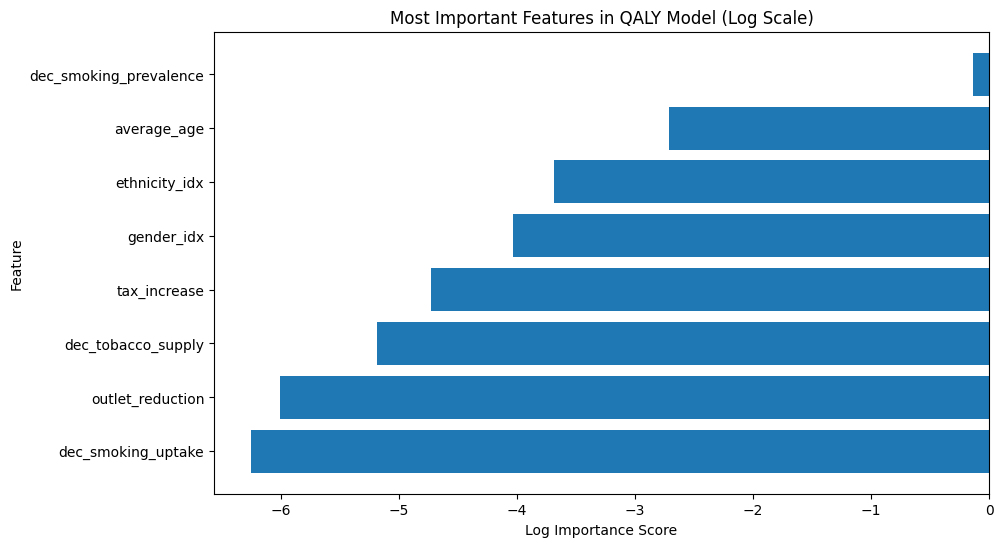

In [26]:
# Get feature importance scores
importance = qaly_xgboost.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_reb.columns, 'Importance': importance})

# Apply log transformation (add a small value to avoid log(0) issues)
importance_df['Log Importance'] = np.log(importance_df['Importance'] + 1e-10)

# Sort by log-transformed importance
importance_df = importance_df.sort_values(by='Log Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Log Importance'])
plt.xlabel('Log Importance Score')
plt.ylabel('Feature')
plt.title('Most Important Features in QALY Model (Log Scale)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [27]:
# Train HSC Model

columns.append('qalys_pc')
X_train = df[columns]
y_train = df[['hs_costs_pc']]

y_flat = y_train.values.flatten() # Ensure that y is a 1D array for compatibility
X_reb, y_reb = knn_samples_rebalanced(X_train.values, y_flat, n_samples=200, random_state=42)
X_reb = pd.DataFrame(X_reb, columns=columns)

hsc_xgboost.fit(X_reb, y_reb)
hsc_pred = hsc_xgboost.predict(pred)



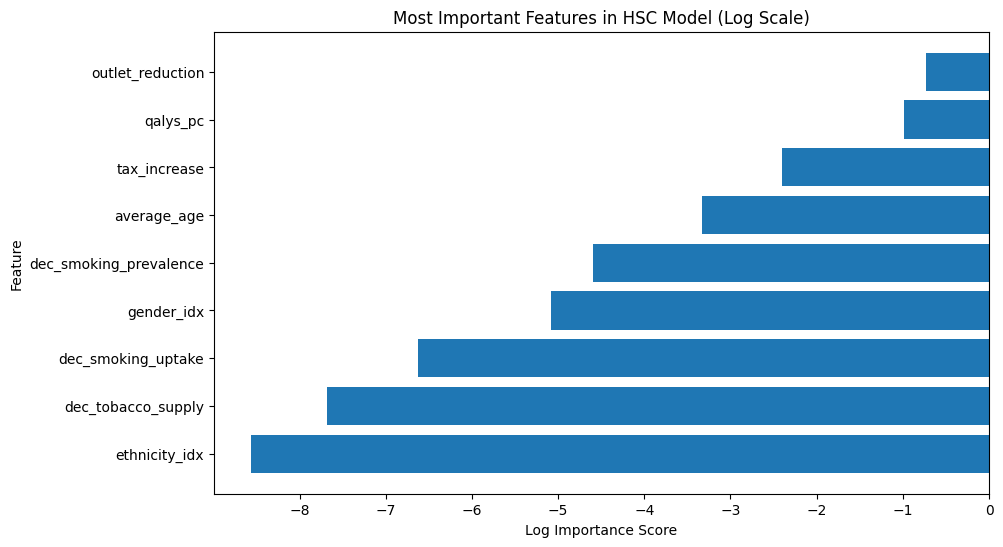

In [28]:
import matplotlib.pyplot as plt

# Get feature importance scores
importance = hsc_xgboost.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_reb.columns, 'Importance': importance})

# Apply log transformation (add a small value to avoid log(0) issues)
importance_df['Log Importance'] = np.log(importance_df['Importance'] + 1e-10)

# Sort by log-transformed importance
importance_df = importance_df.sort_values(by='Log Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Log Importance'])
plt.xlabel('Log Importance Score')
plt.ylabel('Feature')
plt.title('Most Important Features in HSC Model (Log Scale)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [29]:
pred['hs_costs_pc'] = hsc_pred

In [39]:
result = df_vape[['age', 'gender', 'ethnicity']].copy()
result['QALYs'] = pred['qalys_pc']
result['HSCs'] = pred['hs_costs_pc']

In [40]:
# Difference between Full and Partial Training Set

df_full = pd.read_excel('./Datasets/results_full.xlsx')
df_partial = pd.read_excel('./Datasets/results_training.xlsx')
qaly_diff = np.abs((df_full['QALYs'] - df_partial['QALYs']) / df_partial['QALYs'] * 100)
hsc_diff = np.abs((df_full['HSCs'] - df_partial['HSCs']) / df_partial['HSCs'] * 100)
result = df_full[['age', 'gender', 'ethnicity']].copy()
result['QALY_diff/%'] = qaly_diff
result['HSCs_diff/%'] = hsc_diff
result

,age,gender,ethnicity,QALY_diff/%,HSCs_diff/%
0,0-14,Male,non-Māori,5.178271,17.364678
1,15-24,Male,non-Māori,5.744555,0.088291
2,25-44,Male,non-Māori,24.080800,3.727476
3,45-64,Male,non-Māori,0.588858,1.538598
4,65+,Male,non-Māori,443.524564,1422.717568
5,0-14,Female,non-Māori,22.562647,14.955117
6,15-24,Female,non-Māori,9.103566,10.058774
7,25-44,Female,non-Māori,19.582202,3.463063
8,45-64,Female,non-Māori,20.070778,5.060818
9,65+,Female,non-Māori,376.143616,1820.509515


In [39]:
import itertools

models = ['xgboost_model', 'no_bootstrap_reb_model', 'bootstrap_reb_model', 'xgboost_reb_model', 'stacking_reb_model']

# Generate all combinations (1 to 5 models)
all_combinations = []
for r in range(1, 6):  # From 1 model to 5 models
    combinations = list(itertools.combinations(models, r))
    all_combinations.extend(combinations)

# Convert each tuple into a list
all_combinations = [list(combo) for combo in all_combinations]

for i in range(len(all_combinations)):
    print(all_combinations[i])

print(len(all_combinations))

['xgboost_model']
['no_bootstrap_reb_model']
['bootstrap_reb_model']
['xgboost_reb_model']
['stacking_reb_model']
['xgboost_model', 'no_bootstrap_reb_model']
['xgboost_model', 'bootstrap_reb_model']
['xgboost_model', 'xgboost_reb_model']
['xgboost_model', 'stacking_reb_model']
['no_bootstrap_reb_model', 'bootstrap_reb_model']
['no_bootstrap_reb_model', 'xgboost_reb_model']
['no_bootstrap_reb_model', 'stacking_reb_model']
['bootstrap_reb_model', 'xgboost_reb_model']
['bootstrap_reb_model', 'stacking_reb_model']
['xgboost_reb_model', 'stacking_reb_model']
['xgboost_model', 'no_bootstrap_reb_model', 'bootstrap_reb_model']
['xgboost_model', 'no_bootstrap_reb_model', 'xgboost_reb_model']
['xgboost_model', 'no_bootstrap_reb_model', 'stacking_reb_model']
['xgboost_model', 'bootstrap_reb_model', 'xgboost_reb_model']
['xgboost_model', 'bootstrap_reb_model', 'stacking_reb_model']
['xgboost_model', 'xgboost_reb_model', 'stacking_reb_model']
['no_bootstrap_reb_model', 'bootstrap_reb_model', 'xgboo